In [2]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
from sklearn import model_selection
from mel import cross_valid

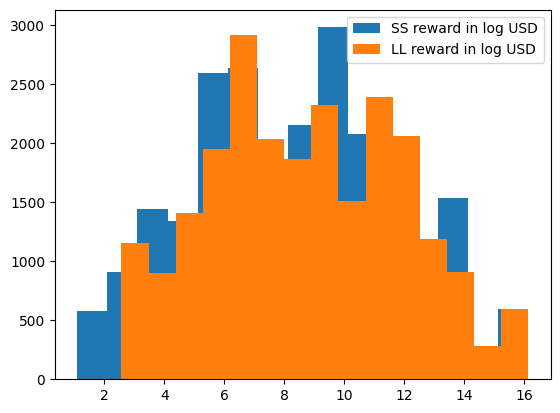

In [61]:
# Load the data from Ericson, et al. (2015)
itch_dt = pd.read_csv('data/ericson_data.csv')
itch_dt = itch_dt.rename(columns={"Subject":"person_id",
                                "Condition":"condition",
                                "Question":"question_id",
                                "X1":"ss_x",
                                "T1":"ss_t",
                                "X2":"ll_x",
                                "T2":"ll_t",
                                "LaterOptionChosen": "choice"}).\
                drop(['R','G','D'],axis=1)


# Plot reward distributions
plt.hist(np.log(itch_dt['ss_x']*100),bins=15,label='SS reward in log USD')
plt.hist(np.log(itch_dt['ll_x']*100),bins=15,label='LL reward in log USD')
plt.legend(loc='best')
plt.show()

In [80]:
# Define features, label, and group variable
features = ['ss_x', 'ss_t', 'll_x', 'll_t',
            'abs_diff_x', 'abs_diff_t', 'rel_diff_x','rel_diff_t',
            'growth_x']
label = 'choice'
group = 'person_id'

# Use the log form of rewards
data_prepare = cross_valid.data_prepare(data=itch_dt,feature=features,label=label,group=group)
data_prepare.generate_features()
dataset = data_prepare._data
dataset[['ss_x','ll_x']] = dataset[['ss_x','ll_x']].apply(lambda x:np.log(x*100))

# Split the data into train sample and test sample
# Train sample containts 80% of the participants, test sample contains the rest 
X_train,X_test,y_train,y_test = data_prepare.split_sample(test_size=0.2)
groups = data_prepare.train_sample[group]

# Split the train sample into K folds (K=10) for cross-validation
sgkf = model_selection.StratifiedGroupKFold(n_splits=10,shuffle=True,random_state=2023)
cv = list(sgkf.split(X=X_train,y=y_train,groups=groups))

In [95]:
# Use XGBoost to fit the data
# Tune the hyer-parameters by grid search 
# The following dictionary directly shows the tuning results 
param_grid = {'n_estimators': [30,40],
              'max_depth': [3],
              'learning_rate': [.1],
              'gamma': [.5],
              'reg_lambda': [.85],
              'subsample': [.6],
              'colsample_bytree': [1.0]
            }

model = xgb.XGBClassifier(objective='binary:logistic')

grid_search = model_selection.GridSearchCV(model, param_grid, 
                                           cv=cv, 
                                           scoring=["accuracy","neg_log_loss",'neg_mean_absolute_error','neg_mean_squared_error'], 
                                           refit="neg_log_loss",
                                           n_jobs=-1,verbose=3)

grid_search.fit(X=X_train,y=y_train,groups=groups)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


GridSearchCV(cv=[(array([    0,     1,     2, ..., 18518, 18519, 18520]),
                  array([  118,   119,   120, ..., 18445, 18446, 18447])),
                 (array([    0,     1,     2, ..., 18518, 18519, 18520]),
                  array([   93,    94,    95, ..., 17830, 17831, 17832])),
                 (array([    0,     1,     2, ..., 18518, 18519, 18520]),
                  array([  392,   393,   394, ..., 18223, 18224, 18225])),
                 (array([    0,     1,     2, ..., 18494, 18495, 18496]),
                  array([  292,   293,   294, ..., 18518, 18519, 18520])),
                 (array([...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.5],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [30, 40], 'reg_lambda': [0.85],
                         'subsample': [0.6]},
             refit='neg_log_loss',
             scoring=['accuracy', 'neg_log_loss', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'],
             verbose=3)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

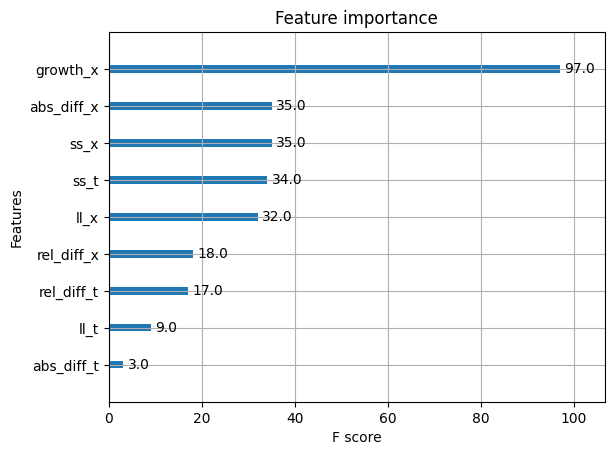

In [96]:
# Save the XGBoost model and check the feature importance
bst_model = grid_search.best_estimator_

with open('my_model_follow_1.pkl', 'wb') as f:
    pickle.dump(bst_model, f)


heuristic_kf_dict = {'dstyle': 'heuristic',
            'ustyle': '--',
            'params': None,
            'accuracy': grid_search.cv_results_['mean_test_accuracy'][0],
            'log_loss': -grid_search.cv_results_['mean_test_neg_log_loss'][0],
            'mse':-grid_search.cv_results_['mean_test_neg_mean_squared_error'][0],
            'mae':-grid_search.cv_results_['mean_test_neg_mean_absolute_error'][0]
            }

xgb.plot_importance(bst_model)

In [19]:
# Plot a decision tree
# To check structure of different trees, change num_trees 
#xgb.to_graphviz(bst_model, num_trees=1)

In [97]:
# Fit data by distounted utility model and trade-off model
style_list = cross_valid.estimation.gen_style_list()
train_sample = data_prepare.train_sample

kf = cross_valid.KFvalidation(style=style_list,data=train_sample,cv=cv,n_jobs=4)
kf.fit()

100%|██████████| 220/220 [47:37<00:00, 12.99s/it] 


In [99]:
# Check if some of the fits fail to converge 
np.where(kf.success==False)

(array([], dtype=int64),)

In [100]:
# Compare models: Cross-validation result
kf_result_df = kf.summary()
kf_result = kf_result_df.drop('style',axis=1)
kf_result = pd.concat([kf_result,pd.DataFrame(heuristic_kf_dict,index=[99])]).sort_values('log_loss')
kf_result

,dstyle,ustyle,params,mse,mae,log_loss,accuracy,pred_ll
99,heuristic,--,None,0.300358,0.300358,0.584141,0.699642,NaN
21,trade,power,"[0.762, 1.801, 79.071, 96.457, 1.522, 2.802]",0.204723,0.409057,0.597668,0.690075,0.239478
1,attention,power,"[0.995, 7.861, 1.309, 1.778]",0.206724,0.413038,0.603405,0.689882,0.241320
3,attention_uni,power,"[9.693, 1.382, 2.231]",0.206864,0.414846,0.603491,0.690412,0.241089
2,attention_uni,cara,"[0.008, 0.002, 0.002]",0.207628,0.416403,0.605173,0.689590,0.232334
20,trade,cara,"[1.101, 1.402, 10.77, 0.017, 0.003, 0.002]",0.208304,0.416649,0.605544,0.682687,0.255863
13,hbmd,power,"[0.224, 1.724, 5.294]",0.208389,0.417653,0.606826,0.687052,0.304782
0,attention,cara,"[0.995, 0.28, 0.05, 0.063]",0.210245,0.420419,0.610551,0.680885,0.204056
12,hbmd,cara,"[96.567, 0.019, 0.015]",0.212787,0.425661,0.615656,0.671966,0.244693
11,hb2,power,"[0.369, 0.264, 0.938, 0.957]",0.220004,0.440376,0.631903,0.658877,0.273996


In [101]:
# Compare models: Out-of-sample performance
test_sample = data_prepare.test_sample
test_result = cross_valid.get_result_tab(kf_result_df,test_sample)

with open('my_model_follow_1.pkl', 'rb') as f:
    heuristic_model = pickle.load(f)

heuristic_test_dict = cross_valid.test_model(style='heuristic',model=heuristic_model,X_test=X_test,y_test=y_test)

test_result = pd.concat([test_result,pd.DataFrame(heuristic_test_dict,index=[99])]).sort_values('accuracy',ascending=False)
test_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
99,heurstic,--,0.194385,0.394314,0.573744,0.711497,0.264859
1,attention,power,0.200871,0.406749,0.589602,0.709328,0.233623
3,attention_uni,power,0.201109,0.408440,0.590008,0.707809,0.231236
21,trade,power,0.198094,0.402269,0.582892,0.701302,0.230803
13,hbmd,power,0.203194,0.412685,0.595404,0.701302,0.294577
20,trade,cara,0.202169,0.407446,0.592214,0.698265,0.269414
2,attention_uni,cara,0.204559,0.412001,0.597311,0.690889,0.161388
12,hbmd,cara,0.207568,0.420132,0.604277,0.688937,0.241866
9,hb,power,0.216968,0.438484,0.625222,0.673536,0.269414
11,hb2,power,0.216327,0.437131,0.623803,0.673536,0.269414


In [105]:
# Randomly draw 1000 questions from the dataset 
# Use the prediction choices of XGBoost as label
# Examine which model can explain the XGBoost's prediction the best
rda_sample = itch_dt[itch_dt.index.isin(np.random.choice(itch_dt.index,size=1000,replace=False))][['ss_x','ss_t','ll_x','ll_t']]
rda_prepare = cross_valid.data_prepare(data=rda_sample)
rda_prepare.generate_features()
rda_sample = rda_prepare._data[features]
rda_sample[['ss_x','ll_x']] = rda_sample[['ss_x','ll_x']].apply(lambda x:np.log(x*100))
rda_sample[label] = heuristic_model.predict(rda_sample[features])

rda_result = cross_valid.get_result_tab(kf_result_df,rda_sample)
rda_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
1,attention,power,0.124520,0.332956,0.420678,0.932,0.238
3,attention_uni,power,0.126845,0.336675,0.426251,0.924,0.230
21,trade,power,0.115081,0.321701,0.402118,0.923,0.237
13,hbmd,power,0.128883,0.340404,0.431643,0.919,0.315
20,trade,cara,0.121331,0.329544,0.415796,0.917,0.285
12,hbmd,cara,0.139060,0.353523,0.455303,0.873,0.247
2,attention_uni,cara,0.134169,0.344003,0.442080,0.868,0.158
18,quasihb_fc,cara,0.166881,0.392809,0.517486,0.831,0.287
16,quasihb,cara,0.158799,0.377859,0.497777,0.831,0.305
19,quasihb_fc,power,0.163120,0.386127,0.508522,0.829,0.287


In [106]:
# Use the predicted choices by the tradeoff model (trade) with power utillity as label
# Examine which model can explain the hbmd's prediction the best
target_kf_row = kf_result_df[(kf_result_df['dstyle']=='trade') & (kf_result_df['ustyle']=='power')]
target_style = target_kf_row['style'].values[0]
target_params = target_kf_row['params'].values[0]

choice_prob = cross_valid.test_model(style=target_style,params=target_params,test_sample=rda_sample,output='predict_proba')
rda_sample[label] = (choice_prob >.5)

rda_result_2 = cross_valid.get_result_tab(kf_result_df,rda_sample).iloc[1:,:]
heuristic_rda_dict = cross_valid.test_model(style='heuristic',model=heuristic_model,test_sample=rda_sample)
rda_result_2 = pd.concat([rda_result_2,pd.DataFrame(heuristic_rda_dict,index=[99])]).sort_values('accuracy',ascending=False)
rda_result_2

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
99,heurstic,--,0.115419,0.318176,0.399705,0.923,0.280
1,attention,power,0.127854,0.336290,0.427565,0.919,0.238
3,attention_uni,power,0.129915,0.339744,0.432609,0.917,0.230
20,trade,cara,0.121894,0.330108,0.417314,0.910,0.285
13,hbmd,power,0.128768,0.340289,0.431330,0.900,0.315
2,attention_uni,cara,0.134567,0.344400,0.443147,0.885,0.158
12,hbmd,cara,0.141673,0.356136,0.460814,0.868,0.247
19,quasihb_fc,power,0.166148,0.389154,0.515124,0.834,0.287
18,quasihb_fc,cara,0.169296,0.395224,0.522644,0.834,0.287
17,quasihb,power,0.166148,0.389154,0.515124,0.834,0.287


In [107]:
# Save the results
kf_result.to_csv("table/itch_follow_1_kf.csv",index=False)
test_result.to_csv("table/itch_follow_1_test.csv",index=False)
rda_result.to_csv("table/itch_follow_1_rda.csv",index=False)